In [1]:
!pip install nltk gensim sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.9 MB/s eta 0:00:00


In [2]:
# 1. Load the libraries/packages
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.corpus import movie_reviews
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer, util

In [3]:
# 2. Download NLTK resources
nltk.download("movie_reviews")
nltk.download("punkt")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# 3. Load movie_reviews dataset and prepare sentences
# movie_reviews.words(fileid) already gives tokenized words
sentences = [list(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]
print(f"Number of documents: {len(sentences)}")
print(sentences[0][:40])

Number of documents: 2000
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and']


In [5]:
# 4. Train a Word2Vec model on movie_reviews
# Word2Vec hyperparameters chosen to be small & fast
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # embedding size
    window=5,          # context window
    min_count=3,       # ignore rare words
    workers=4,         # number of CPU cores to use
    sg=1,              # 1 = skip-gram; 0 = CBOW
    epochs=10          # training iterations
)

print("Word2Vec training complete!")
print("Vocabulary size:", len(w2v_model.wv))


Word2Vec training complete!
Vocabulary size: 20261


In [7]:
# 5. Explore word similarities (Word2Vec)

def show_similar_words(word, topn=10):
    if word not in w2v_model.wv:
        print(f"'{word}' not in vocabulary.")
        return
    print(f"\nTop {topn} words similar to '{word}':")
    for sim_word, score in w2v_model.wv.most_similar(word, topn=topn):
        print(f"{sim_word:15s}  ->  {score:.3f}")

show_similar_words("good")
show_similar_words("bad",5)
show_similar_words("movie",3)



Top 10 words similar to 'good':
decent           ->  0.716
great            ->  0.704
bad              ->  0.689
passable         ->  0.638
gutsy            ->  0.637
lousy            ->  0.628
dopey            ->  0.612
pitiful          ->  0.611
precocious       ->  0.607
nice             ->  0.603

Top 5 words similar to 'bad':
good             ->  0.689
crappy           ->  0.658
awful            ->  0.644
terrible         ->  0.637
stupid           ->  0.629

Top 3 words similar to 'movie':
film             ->  0.900
turkey           ->  0.747
flick            ->  0.717


In [8]:
# 6. Cosine similarity between word embeddings

def cosine_similarity(word1, word2):
    if word1 not in w2v_model.wv or word2 not in w2v_model.wv:
        print(f"One of the words ('{word1}', '{word2}') is not in vocabulary.")
        return None
    v1 = w2v_model.wv[word1]
    v2 = w2v_model.wv[word2]
    sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return sim

pairs = [
    ("good", "great"),
    ("good", "bad"),
    ("good", "excellent"),
    ("bad", "terrible"),
    ("movie", "film"),
    ("movie", "dog")
]

print("\nCosine similarities between word pairs (Word2Vec):")
for w1, w2 in pairs:
    sim = cosine_similarity(w1, w2)
    if sim is not None:
        print(f"{w1:8s} vs {w2:9s} -> {sim:.3f}")



Cosine similarities between word pairs (Word2Vec):
good     vs great     -> 0.704
good     vs bad       -> 0.689
good     vs excellent -> 0.522
bad      vs terrible  -> 0.637
movie    vs film      -> 0.900
movie    vs dog       -> 0.207


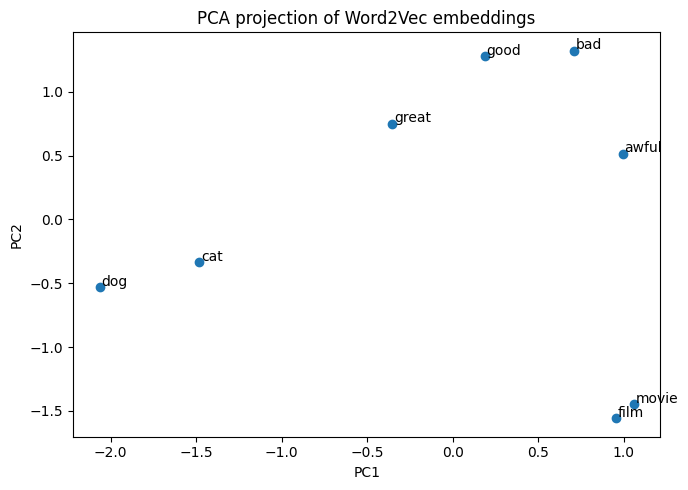

In [9]:
# 7. Visualize a few word embeddings using PCA

words_to_plot = ["good", "great", "bad", "awful", "movie", "film", "dog", "cat"]
existing_words = [w for w in words_to_plot if w in w2v_model.wv]

vectors = np.array([w2v_model.wv[w] for w in existing_words])

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

plt.figure(figsize=(7, 5))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(existing_words):
    plt.annotate(word, (reduced[i, 0] + 0.01, reduced[i, 1] + 0.01))

plt.title("PCA projection of Word2Vec embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [10]:
# 8. Sentence Embeddings using Sentence-BERT (SBERT)

# Load a lightweight SBERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
print("\nSBERT model loaded.")

sentences = [
    "I love this movie, it was amazing!",
    "This film was terrible and boring.",
    "The movie was okay, not great but not bad.",
    "I really enjoyed this film, it was fantastic.",
    "The plot was dull and the acting was bad."
]

sentence_embeddings = sbert_model.encode(sentences, convert_to_tensor=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


SBERT model loaded.


In [11]:
# 9. Compute pairwise sentence similarity

similarity_matrix = util.cos_sim(sentence_embeddings, sentence_embeddings)
similarity_df = pd.DataFrame(
    similarity_matrix.cpu().numpy(),
    index=[f"S{i}" for i in range(len(sentences))],
    columns=[f"S{i}" for i in range(len(sentences))]
)

print("\nSentences:")
for i, s in enumerate(sentences):
    print(f"S{i}: {s}")

print("\nCosine similarity matrix between sentences (SBERT):")
display(similarity_df.round(3))


Sentences:
S0: I love this movie, it was amazing!
S1: This film was terrible and boring.
S2: The movie was okay, not great but not bad.
S3: I really enjoyed this film, it was fantastic.
S4: The plot was dull and the acting was bad.

Cosine similarity matrix between sentences (SBERT):


,S0,S1,S2,S3,S4
S0,1.000,0.378,0.548,0.809,0.296
S1,0.378,1.000,0.650,0.493,0.678
S2,0.548,0.650,1.000,0.665,0.590
S3,0.809,0.493,0.665,1.000,0.404
S4,0.296,0.678,0.590,0.404,1.000


In [12]:
# 10. Show most similar sentence for each input

def show_most_similar_sentence(sent_list):
    emb = sbert_model.encode(sent_list, convert_to_tensor=True)
    sim = util.cos_sim(emb, sentence_embeddings)  # compare to our base sentences

    for i, query in enumerate(sent_list):
        sims = sim[i].cpu().numpy()
        best_idx = int(np.argmax(sims))
        print(f"\nQuery: {query}")
        print(f"Most similar: {sentences[best_idx]}")
        print(f"Similarity score: {sims[best_idx]:.3f}")

test_queries = [
    "I hated this movie, it was so bad.",
    "One of the best films I have ever seen.",
    "It was an average film."
]

show_most_similar_sentence(test_queries)


Query: I hated this movie, it was so bad.
Most similar: This film was terrible and boring.
Similarity score: 0.735

Query: One of the best films I have ever seen.
Most similar: I really enjoyed this film, it was fantastic.
Similarity score: 0.662

Query: It was an average film.
Most similar: This film was terrible and boring.
Similarity score: 0.567
